In [146]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy.units as u
from matplotlib import cm
import time

import healpy as hp
import pandas as pd
from sklearn.neighbors import KDTree

In [2]:
# -------------------------------------------------------------------------------
# plotting settings
# -------------------------------------------------------------------------------

colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple", "pale red"]
colors = sns.xkcd_palette(colors)
#colors = sns.color_palette("Blues")

matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)
fsize = 18

colors_cont = ["black", "grey", "light grey"] 
colors_cont = sns.xkcd_palette(colors_cont)

np.random.seed(40)

## Read in data

In [3]:
tab_gaia = Table.read('../data/gaia_wise_panstarrs_tmass.fits.gz', format='fits')
print('Total number of Gaia quasars:', len(tab_gaia))

number of quasars: 6649162


In [4]:
tab_gaia.columns

<TableColumns names=('ra','dec','redshift_qsoc','l','b','source_id','parallax','parallax_error','pmra','pmra_error','pmdec','pmdec_error','astrometric_excess_noise','visibility_periods_used','ipd_frac_multi_peak','ruwe','phot_g_n_obs','phot_g_mean_flux','phot_g_mean_flux_error','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','phot_bp_rp_excess_factor','in_qso_candidates','gaia_crf_source','vari_best_class_name','vari_best_class_score','fractional_variability_g','qso_variability','non_qso_variability','vari_agn_membership_score','classprob_dsc_combmod_quasar','classprob_dsc_combmod_galaxy','classlabel_dsc','classlabel_dsc_joint','classlabel_oa','redshift_qsoc_lower','redshift_qsoc_upper','zscore_qsoc','flags_qsoc','n_transits','intensity_quasar','intensity_quasar_error','host_galaxy_detected','intensity_hostgalaxy','intensity_hostgalaxy_error','radius_hostgalaxy','radius_hostgalaxy_error','host_galaxy_flag','source_selection_flags','allwise_oid','designation','w1mpro','w2mpro','

In [5]:
tab_sdss = Table.read('../data/SDSS_DR16Q_v4.fits', format='fits') 
print('Total number of SDSS quasars:', len(tab_sdss))

Include only SDSS quasars with z>0.01 (this removes zeros and nans, and maybe a few others)

In [ ]:
z_min = 0.01
idx_sdssgood = tab_sdss['Z'] > z_min
tab_sdss = tab_sdss[idx_sdssgood]
print(f'Number of SDSS quasars with: z < {z_min}: {len(tab_sdss)}')

Cross-match SDSS and Gaia

In [7]:
coords_sdss = SkyCoord(ra=tab_sdss['RA']*u.degree, dec=tab_sdss['DEC']*u.degree, frame='icrs')    
coords_gaia = SkyCoord(ra=tab_gaia['ra'], dec=tab_gaia['dec'], frame='icrs') 
cross_sdss_gaia = coords_gaia.search_around_sky(coords_sdss, 1*u.arcsec) # Hogg thinks this is idiotic

Make new table, tab_xmatch, with only gaia objects with SDSS match

In [8]:
tab_xmatch = tab_gaia[cross_sdss_gaia[1]]
tab_sdss = tab_sdss[cross_sdss_gaia[0]]
print(f'Number of Gaia quasars with SDSS match (with z min cut): {len(tab_xmatch)}')

(407236, 407236)

In [112]:
tab_xmatch.add_column(tab_sdss['Z'], name='redshift_sdss')

## Dust map

Load in Schlegel, Finkbeiner & Davis (1998) dust map from the dustmaps package

In [9]:
# only do this the first time!
fetch_map = False
if fetch_map:
    from dustmaps.config import config
    config['data_dir'] = '/Users/ksf/code/nyu/research/gaia-quasars-lss/data/dustmaps'

    import dustmaps
    import dustmaps.sfd
    dustmaps.sfd.fetch()

In [10]:
from dustmaps.sfd import SFDQuery
sfd = SFDQuery()

Get reddening E(B-V) from dust map at each of the cross-matched quasars:

E(B-V): https://astronomy.swin.edu.au/cosmos/i/interstellar+reddening

In [11]:
coords = SkyCoord(ra=tab_xmatch['ra'], dec=tab_xmatch['dec'], frame='icrs') 

In [ ]:
ebv = sfd(coords)

In [ ]:
tab_xmatch.add_column(ebv, name='ebv')

Text(0.5, 0, 'EBV')

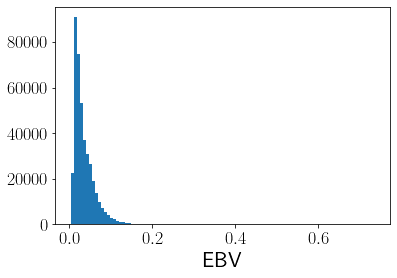

In [13]:
plt.hist(ebv, bins=100)
plt.xlabel('E(B-V)')
plt.ylabel('number per bin')

Plot extinction for SDSS matched quasars:

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(tab_xmatch['ra'], tab_xmatch['dec'], c=ebv, s=0.1, alpha=0.1, cmap='inferno', vmax=0.1)
plt.colorbar()

In [ ]:
plt.figure(figsize=(8,6))
b = tab_xmatch["b"] * np.pi/180
plt.scatter(tab_xmatch['l'], b, c=ebv, s=0.1, alpha=0.1, cmap='inferno', vmax=0.1)
plt.colorbar()

Get extinction for full Gaia sample (will be used for application of method):

In [15]:
ebv_gaia = sfd(coords_gaia)

In [167]:
tab_gaia.add_column(ebv_gaia, name='ebv')

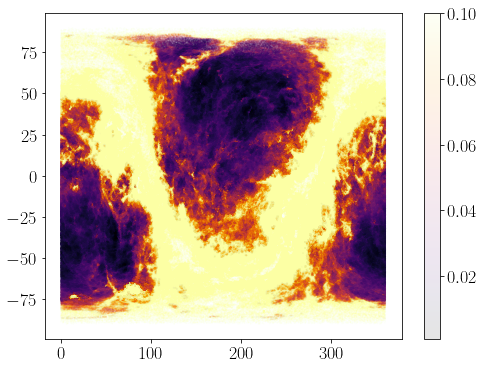

In [16]:
plt.figure(figsize=(8,6))
plt.scatter(tab_gaia['ra'], tab_gaia['dec'], c=ebv_gaia, s=0.1, alpha=0.1, cmap='inferno', vmax=0.1)
plt.colorbar()

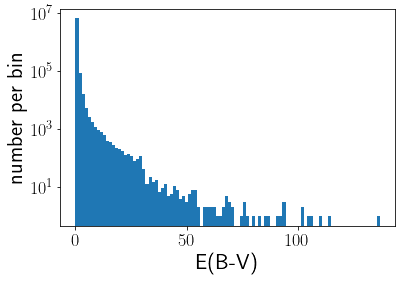

In [73]:
plt.hist(ebv_gaia, bins=100)
plt.xlabel('E(B-V)')
plt.ylabel('number per bin')
plt.yscale('log')

In [ ]:
plt.figure(figsize=(8,6))
b = tab_gaia["b"] * np.pi/180
plt.scatter(tab_gaia['l'], b, c=ebv_gaia, s=0.1, alpha=0.1, cmap='inferno', vmax=0.1)
plt.colorbar()

## Color features

Colors, all Gaia:

In [17]:
# ALL GAIA
# wise
w1_w2_gaia = np.array(tab_gaia['w1mpro']) - np.array(tab_gaia['w2mpro'])
g_w1_gaia = np.array(tab_gaia['phot_g_mean_mag']) - np.array(tab_gaia['w1mpro']) # think was error before, w2 instead of w1

Colors, cross-match:

In [18]:
# SDSS cross-match
# gaia
bp_g = np.array(tab_xmatch['phot_bp_mean_mag'] - tab_xmatch['phot_g_mean_mag'])
g_rp = np.array(tab_xmatch['phot_g_mean_mag']) - np.array(tab_xmatch['phot_rp_mean_mag'])
bp_rp = np.array(tab_xmatch['phot_bp_mean_mag']) - np.array(tab_xmatch['phot_rp_mean_mag'])

# wise
w1_w2 = np.array(tab_xmatch['w1mpro']) - np.array(tab_xmatch['w2mpro'])
g_w1 = np.array(tab_xmatch['phot_g_mean_mag']) - np.array(tab_xmatch['w1mpro']) # think was error before, w2 instead of w1

Band values, cross-match:

In [19]:
# SDSS cross-match
# gaia
g = np.array(tab_xmatch['phot_bp_mean_mag'])
rp = np.array(tab_xmatch['phot_rp_mean_mag'])
bp = np.array(tab_xmatch['phot_bp_mean_mag'])

# wise
w1 = np.array(tab_xmatch['w1mpro'])
w2 = np.array(tab_xmatch['w2mpro'])

Check out color space of quasars, & choose cuts to isolate them:

In [ ]:
w1_w2_min = 0.1
g_w1_min = 2.2

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(g_w1_gaia, w1_w2_gaia, s=1, alpha=0.1, color='orange')
plt.scatter(g_w1, w1_w2, s=1, alpha=0.1, color='blue')
plt.axhline(w1_w2_min,color='k')
plt.axvline(g_w1_min,color='k')
plt.xlabel('G-W1')
plt.ylabel('W1-W2')

In [22]:
index = (w1_w2 > w1_w2_min) & (g_w1 > g_w1_min)
print('Fraction of SDSS quasars that make color cuts:', np.sum(index) / np.sum(np.isfinite(w1_w2)))

0.9954064495971255


Color cut + magnitude cut

In [90]:
idx_qso = (w1_w2 > 0.1) & (g_w1 > 2.2)   
idx_gmag = (tab_xmatch['phot_g_mean_mag'] < 20)
idx_photoz = idx_qso & idx_gmag                  
print('Fraction of Gaia-SDSS cross-matched quasars that make cuts:', np.sum(idx_photoz)/len(tab_xmatch))

Fraction of Gaia-SDSS cross-matched quasars that make cuts: 0.4173108467817187


## Features

In [ ]:
def construct_X_and_Y(table, mode='colors', rescale_X=True):
    assert mode in ['colors', 'magnitudes'], print("Mode not recognized!")
    
    redshift_qsoc = np.array(tab_xmatch['redshift_qsoc'])
    
    g = np.array(table['phot_bp_mean_mag'])
    rp = np.array(table['phot_rp_mean_mag'])
    bp = np.array(table['phot_bp_mean_mag'])

    # wise
    w1 = np.array(table['w1mpro'])
    w2 = np.array(table['w2mpro'])

    if mode=='colors':
        X = np.vstack([redshift_qsoc, ebv,
                   bp-g, g-rp, bp-rp, w1-w2, g-w1, 
                   ]).T

    if mode=='magnitudes':
        X = np.vstack([redshift_qsoc, ebv,
                   g, bp, rp, w1, w2, 
                   ]).T
    
    idx_good = np.all(np.isfinite(X), axis=1)
    X = X[idx_good]

    if rescale_X:
        stds = np.std(X, axis=0)
        means = np.mean(X, axis=0)
        X = (X-means)/stds
    
    Y = table['redshift_sdss'][idx_good]
    print(X.shape, Y.shape)
    
    return X, Y

In [ ]:
X, Y = construct_X_and_Y(tab_xmatch[idx_photo_z], mode='colors')

## Perform cross-validation

Set up samples (loo = leave one out)

In [26]:
n_samples = 8
np.random.seed(17)
loo_samples = np.random.choice(np.arange(n_samples), replace=True, size=X.shape[0])
print(loo_samples)

[7 1 7 ... 7 5 3]


For now, just choosing one of the samples

In [27]:
loo_sample = 3
train = loo_samples != loo_sample
valid = loo_samples == loo_sample
X_train, Y_train = X[train], Y[train]
X_valid, Y_valid = X[valid], Y[valid]

Construct kdtree

In [30]:
tree = KDTree(X_train)

Query neighbors

In [31]:
# guessing 11 for now - hogg's intuition
K = 11
dists, inds = tree.query(X_valid, k=K)
print(dists.shape, inds.shape)

(21114, 11) (21114, 11)


Choose our best photoz estimate to be the median SDSS (training) redshift of the nearest neighbors; also get lower and upper percentiles

In [32]:
low_z, Y_hat_valid, up_z = np.percentile(Y_train[inds], (2.5, 50, 97.5), axis=1)
sigma_z = (up_z - low_z)/4

Plot results

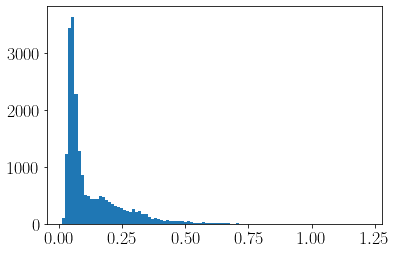

In [33]:
plt.hist(sigma_z, histtype='step', bins=50)
plt.xlabel(r'$\sigma_z$')
plt.ylabel(r'Number per bin')

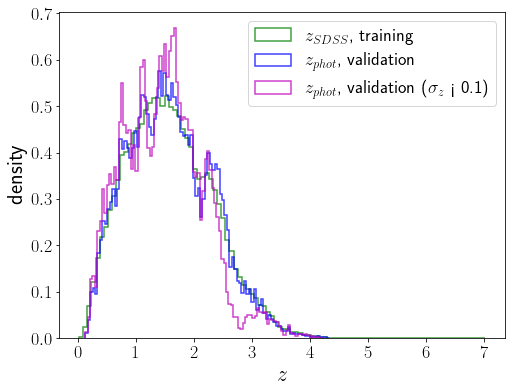

In [124]:
alpha = 0.75
lw = 1.5
density = True
histtype='step'

plt.figure(figsize=(8,6))
_ = plt.hist(Y_train, bins=100, alpha=alpha, color='g', lw=lw,
             density=density, histtype=histtype, label=r'$z_{SDSS}$, training')
_ = plt.hist(Y_hat_valid, bins=100, alpha=alpha, color='b', lw=lw,
             density=density, histtype=histtype, label=r'$z_{phot}$, validation')
_ = plt.hist(Y_hat_valid[sigma_z < 0.1], bins=100, alpha=alpha, color='m', lw=lw, 
             density=density, histtype=histtype, label=r'$z_{phot}$, validation ($\sigma_z$ < 0.1)')
plt.xlabel(r'$z$')
plt.ylabel('density')
plt.legend()

Text(0, 0.5, 'redshift estimate (Gaia QSOC + photometry + SFD)')

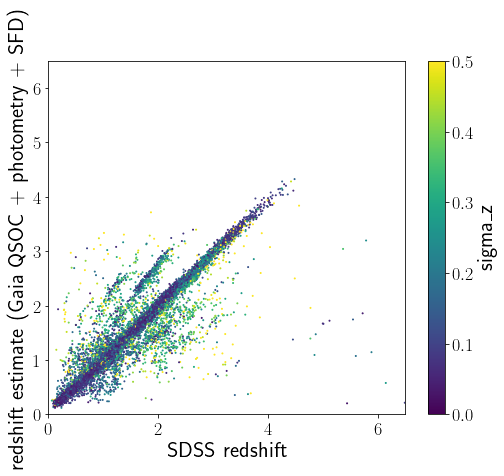

In [49]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
sc = ax.scatter(Y_valid, Y_hat_valid, s = 1, c=sigma_z, vmin=0, vmax=0.5)
cbar = plt.colorbar(sc, label=r'$\sigma_z$')
ax.set_xlim(0, 6.5)
ax.set_ylim(0, 6.5)
plt.xlabel('SDSS redshift')
plt.ylabel('redshift estimate (Gaia QSOC + photometry + SFD)')

In [37]:
z_err_close = 0.2
frac_recovered_baseline = np.sum(np.abs(Y_valid - X_valid[:,0]) < z_err_close) / len(Y_valid)
frac_recovered = np.sum(np.abs(Y_valid - Y_hat_valid) < z_err_close) / len(Y_valid)
print(frac_recovered_baseline)
print(frac_recovered)

0.8205456095481671
0.8813583404376243


In [140]:
percentile_vals = [50, 80, 90, 95, 98]
percentiles = np.percentile(np.abs(Y_valid - Y_hat_valid), percentile_vals)
print(f'The {percentile_vals} percentiles of redshift errors are:')
print([float(f"{p:.3f}") for p in percentiles])

The [50, 80, 90, 95, 98] percentiles of redshift errors are:
[0.039, 0.098, 0.279, 0.624, 0.95]


Text(0, 0.5, 'number per bin')

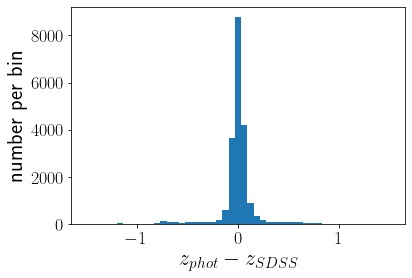

In [144]:
bins = np.linspace(-1.5, 1.5, 50)
plt.hist(Y_valid - Y_hat_valid, bins=bins)
plt.xlabel(r'$z_{phot} - z_{SDSS}$')
plt.ylabel('number per bin')

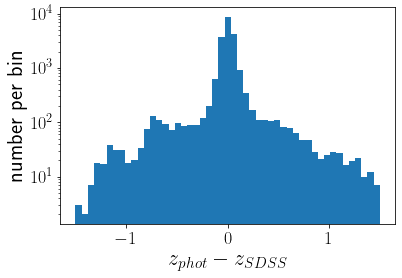

In [145]:
bins = np.linspace(-1.5, 1.5, 50)
plt.hist(Y_valid - Y_hat_valid, bins=bins)
plt.xlabel(r'$z_{phot} - z_{SDSS}$')
plt.ylabel('number per bin')
plt.yscale('log')

# Whole sample

In [92]:
idx_gaia_qso = (w1_w2_gaia > 0.1) & (g_w1_gaia > 2.2)  
idx_gaia_gmag = (tab_gaia['phot_g_mean_mag'] < 20.2)  
print(np.sum(idx_gaia_qso)/len(tab_gaia))
print(np.sum(idx_gaia_gmag)/len(tab_gaia))

0.24121972062043306
0.38286298333534363


In [93]:
idx_gaia_photoz = idx_gaia_qso & idx_gaia_gmag   
print(np.sum(idx_gaia_photoz), len(tab_gaia))

875927 6649162


# Healpix 

Generate pixels

In [ ]:
# healpix grids have npix = 12*nside^2. want n_qso_per_pix=10-20 QS0s per pixel, so if we have n_qso quasars, we want:
# nside = sqrt((n_qso/n_qso_per_pix)/12)

In [252]:
n_qso = len(tab_gaia[idx_gaia_photoz])
n_qso_per_pix = 15
NSIDE = round(np.sqrt((n_qso/n_qso_per_pix)/12))
print(NSIDE)

70


In [253]:
print("Approximate resolution at NSIDE {} is {:.2} deg".format(NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60))

Approximate resolution at NSIDE 70 is 0.84 deg


In [254]:
NPIX = hp.nside2npix(NSIDE)
print(NPIX)

58800


In [255]:
pixel_arr = np.arange(NPIX)

Apply to data

In [256]:
pixel_indices = hp.ang2pix(NSIDE, tab_gaia['ra'][idx_gaia_photoz], tab_gaia['dec'][idx_gaia_photoz], lonlat=True)

In [257]:
av_gaia_photoz = 3.2 * tab_gaia['ebv'][idx_gaia_photoz]
len(av_gaia_photoz)

875927

In [258]:
# copied from https://stackoverflow.com/questions/49372918/group-numpy-into-multiple-sub-arrays-using-an-array-of-values
def groupby(values, group_indices):
    # Get argsort indices, to be used to sort a and b in the next steps
    sidx = group_indices.argsort(kind='mergesort')
    values_sorted = values[sidx]
    group_indices_sorted = group_indices[sidx]

    # Get the group limit indices (start, stop of groups)
    cut_idx = np.flatnonzero(np.r_[True,group_indices_sorted[1:] != group_indices_sorted[:-1],True])

    # Split input array with those start, stop ones
    values_grouped = [values_sorted[i:j] for i,j in zip(cut_idx[:-1],cut_idx[1:])]
    return values_grouped, list(set(group_indices_sorted))

In [259]:
# this is too slow, use groupby
# av_mean = [np.mean(av_gaia_gmag[np.where(pixel_idx == pixel_indices)]) for pixel_idx in pixel_indices]
av_grouped, pixel_indices_sorted = groupby(av_gaia_photoz, pixel_indices)

Check number per pixel

In [260]:
n_per_pixel = np.array([len(avs) for avs in av_grouped])

Text(0, 0.5, 'number per (histogram) bin')

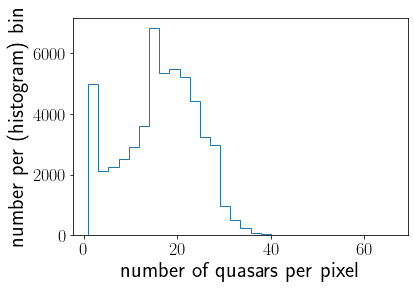

In [264]:
plt.hist(n_per_pixel, bins=30, histtype='step')
plt.xlabel('number of quasars per pixel')
plt.ylabel('number per (histogram) bin')

In [265]:
av_means = np.array([np.mean(avs) for avs in av_grouped])

In [266]:
map_av = np.zeros(NPIX)
map_av[pixel_indices_sorted] = av_means

In [267]:
pixels_nodata = list(set(pixel_arr) - set(pixel_indices_sorted))
map_av[pixels_nodata] = np.nan

0.0 180.0 -180.0 180.0


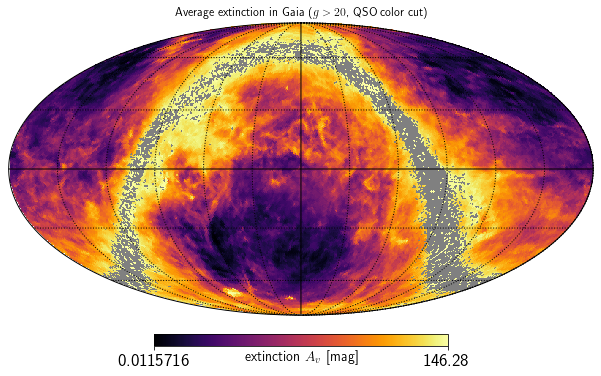

In [268]:
hp.mollview(
    map_av,
    title=r"Average extinction in Gaia ($g > 20$, QSO color cut)",
    unit=r"extinction $A_v$ [mag]",
    norm="hist",
    cmap='inferno',
    #min=-1,
    #max=1,
)
hp.graticule()

0.0 180.0 -180.0 180.0


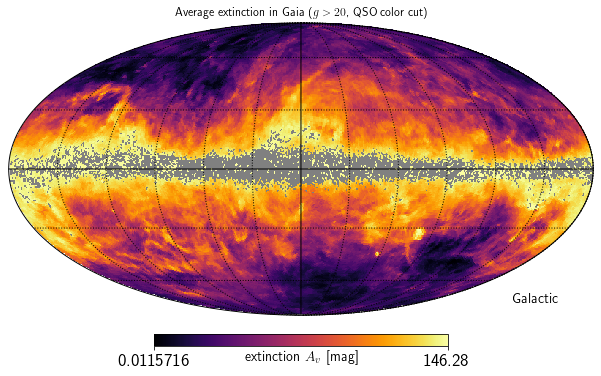

In [269]:
hp.mollview(
    map_av,
    title=r"Average extinction in Gaia ($g > 20$, QSO color cut)",
    unit=r"extinction $A_v$ [mag]",
    norm="hist",
    cmap='inferno',
    coord=['C', 'G']
    #min=-1,
    #max=1,
)
hp.graticule()

In [321]:
map_nqso = np.zeros(NPIX)
map_nqso[pixel_indices_sorted] = n_per_pixel

0.0 180.0 -180.0 180.0


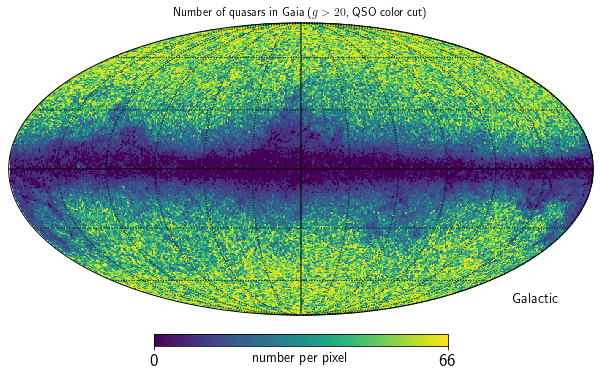

In [325]:
hp.mollview(
    map_nqso,
    title=r"Number of quasars in Gaia ($g > 20$, QSO color cut)",
    unit=r"number per pixel",
    norm="hist",
    cmap='viridis',
    coord=['C', 'G']
    #min=-1,
    #max=1,
)
hp.graticule()

Random catalog

In [293]:
N_rand = n_qso*10
us = np.random.uniform(size=N_rand)
vs = np.random.uniform(size=N_rand)
theta_rand = 2 * np.pi * us
phi_rand = np.arccos(2*vs-1)

In [298]:
ra_rand = (theta_rand * 180/np.pi) * u.deg
dec_rand = (phi_rand * 180/np.pi - 90) * u.deg

In [299]:
coords_rand = SkyCoord(ra=ra_rand, dec=dec_rand, frame='icrs') 

In [300]:
ebv_rand = sfd(coords_rand)

In [301]:
av_rand = 3.2*ebv_rand

In [309]:
pixel_indices_rand = hp.ang2pix(NSIDE, ra_rand.value, dec_rand.value, lonlat=True)

In [311]:
av_grouped_rand, pixel_indices_sorted_rand = groupby(av_rand, pixel_indices_rand)

In [312]:
av_means_rand = np.array([np.mean(avs) for avs in av_grouped_rand])

In [313]:
map_av_rand = np.zeros(hp.nside2npix(NSIDE))
map_av_rand[pixel_indices_sorted_rand] = av_means_rand

In [314]:
# pixels_nodata = list(set(pixel_arr) - set(pixel_indices_sorted))
# map_av[pixels_nodata] = np.nan

0.0 180.0 -180.0 180.0


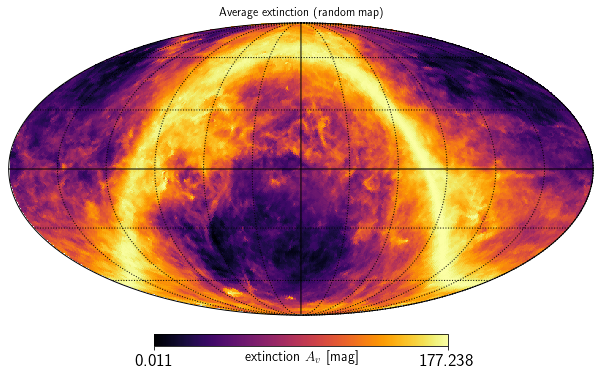

In [315]:
hp.mollview(
    map_av_rand,
    title=r"Average extinction (random map)",
    unit=r"extinction $A_v$ [mag]",
    norm="hist",
    cmap='inferno',
    #min=-1,
    #max=1,
)
hp.graticule()

0.0 180.0 -180.0 180.0


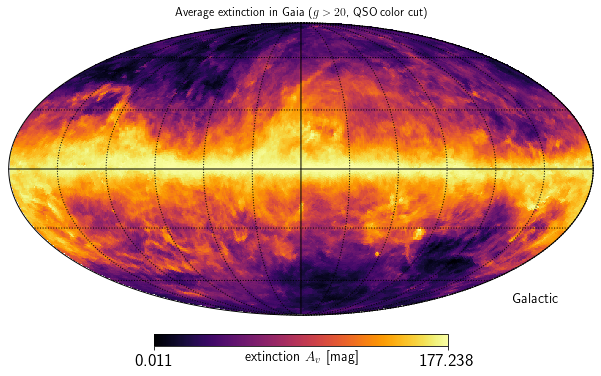

In [317]:
hp.mollview(
    map_av_rand,
    title=r"Average extinction in Gaia ($g > 20$, QSO color cut)",
    unit=r"extinction $A_v$ [mag]",
    norm="hist",
    cmap='inferno',
    coord=['C', 'G']
    #min=-1,
    #max=1,
)
hp.graticule()

In [319]:
len(n_per_pixel), len(av_means_rand)

(53805, 58800)

TODO: make n_per_pixel in sorted order of pixels, adding zeros where none, to be able to compare to av_means

Text(0, 0.5, 'number of QSOs in pixel')

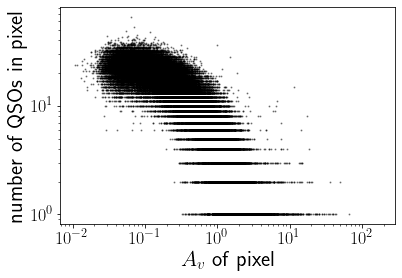

In [330]:
plt.scatter(map_av_rand, map_nqso, color='k', s=1, alpha=0.4)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(f'$A_v$ of pixel')
plt.ylabel(f'number of QSOs in pixel')

# Investigate number counts

In [53]:
area_gaia = 4*np.pi*(360/(2*np.pi))**2
print(area_gaia)

41252.96124941928


All gaia quasars

In [276]:
g_gaia_photoz = tab_gaia['phot_g_mean_mag'][idx_gaia_photoz]
# manually set mag_min, bc its 2.1!
mag_min = 13
mag_max = np.max(g_gaia_photoz)
print(mag_min, mag_max)

bin_width = 0.25
bin_fac = 1/bin_width
mag_bins = np.arange(np.floor(mag_min*bin_fac)/bin_fac, np.ceil(mag_max*bin_fac)/bin_fac+bin_width, bin_width)
print(mag_bins)
weights = np.full(len(g_gaia_photoz), 1/area_gaia)

13 20.199999
[13.   13.25 13.5  13.75 14.   14.25 14.5  14.75 15.   15.25 15.5  15.75
 16.   16.25 16.5  16.75 17.   17.25 17.5  17.75 18.   18.25 18.5  18.75
 19.   19.25 19.5  19.75 20.   20.25]


In [277]:
#av_gaia_photoz = 3.2*ebv_gaia[idx_gaia_ph]

In [286]:
av_max = 1
idx_lowext = (av_gaia_photoz < av_max)
idx_highext = (av_gaia_photoz >= av_max)
print(np.sum(idx_lowext)/len(idx_lowext))

0.9764626504263483


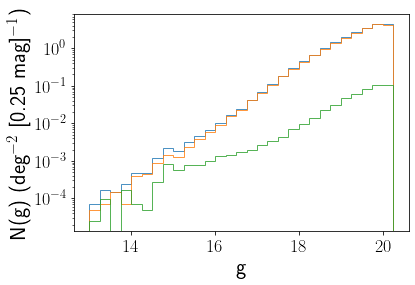

In [289]:
alpha=0.8
histtype='step'
plt.hist(g_gaia_photoz, bins=mag_bins, weights=weights, alpha=alpha, histtype=histtype, label='Gaia QSOs (G<20)')
plt.hist(g_gaia_photoz[idx_lowext], bins=mag_bins, weights=weights[idx_lowext], alpha=alpha, histtype=histtype, 
         label=r'with $A_v < '+str(av_max))
plt.hist(g_gaia_photoz[idx_highext], bins=mag_bins, weights=weights[idx_highext], alpha=alpha, histtype=histtype, 
         label=r'with $A_v >= '+str(av_max))
plt.xlabel('g')
plt.ylabel(r'N(g) (deg$^{-2}$ [0.25 mag]$^{-1}$)')

plt.yscale('log')

In [102]:
np.min(ebv_gaia[idx_gaia_qso]), np.max(ebv_gaia[idx_gaia_qso])

(0.0010600771, 45.712547)

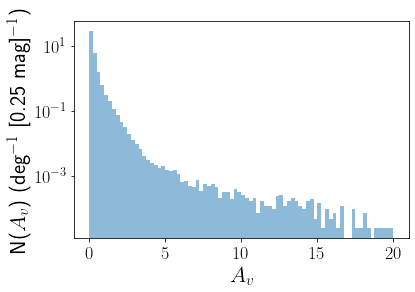

In [105]:
alpha=0.5
Av_bins = np.arange(0, 20+bin_width, bin_width)
plt.hist(Av_gaia_qso, bins=Av_bins, weights=weights, alpha=alpha)
plt.xlabel('$A_v$')
plt.ylabel(r'N($A_v$) (deg$^{-1}$ [0.25 mag]$^{-1}$)')

plt.yscale('log')

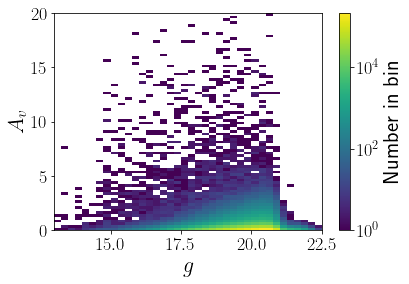

In [107]:
plt.hist2d(g_gaia_qso, Av_gaia_qso, bins=[mag_bins, Av_bins], norm=matplotlib.colors.LogNorm())
plt.xlabel(r'$g$')
plt.ylabel(r'$A_v$')
plt.colorbar(label='Number in bin')

In [ ]:
mag_min = 13
mag_max = np.max(g_gaia)
print(mag_min, mag_max)

bin_width = 0.25
bin_fac = 1/bin_width
mag_bins = np.arange(np.floor(mag_min*bin_fac)/bin_fac, np.ceil(mag_max*bin_fac)/bin_fac+bin_width, bin_width)

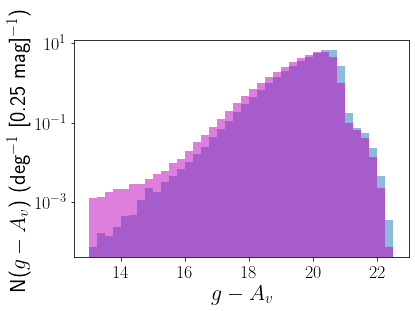

In [110]:
alpha=0.5
plt.hist(g_gaia_qso, bins=mag_bins, weights=weights, alpha=alpha)
plt.hist(g_gaia_qso-Av_gaia_qso, bins=mag_bins, weights=weights, alpha=alpha, color='m')
plt.xlabel('$g - A_v$')
plt.ylabel(r'N($g-A_v$) (deg$^{-1}$ [0.25 mag]$^{-1}$)')

plt.yscale('log')

#